# AutoML with TPOT using Adversary Emulation (C2) as datagen - Supervised and Deep Learning with Genetic Programming

# Installations

The installation is mostly automated.

A file in the same directory named "thesis_ro" will be required, which should contain your GitHub read-only token.

The file has one line:


`echo "GITHUB_PERSONAL_ACCESS_TOKEN="ghp_..." > thesis_ro`

In [1]:
import sys
import os
import subprocess

IN_COLAB = 'google.colab' in sys.modules

if not IN_COLAB:
  pass

else:
  subprocess.run('''
    source <(curl -s https://raw.githubusercontent.com/norandom/log2ml/main/dependencies/install.sh)
    ''',
    shell=True, check=True, executable='/bin/bash')



In [2]:
from dotenv import load_dotenv
import os

load_dotenv("thesis_ro", verbose=True)  # take environment variables from the file
token = os.getenv('GITHUB_PERSONAL_ACCESS_TOKEN')
if len(token) > 0:
  print("ok")
else:
  print("no token")

ok


# Data download: captured Sysmon logs from the AE lab

These samples contain Sysmon log activity of Dropper Malware (C2 Dropper, MS Excel VBA, Covenant).

No AE campaigns, just the Dropper itself.

We are looking at 1000 documents, some malicious and some not. Which ones are malicious? How does the VBA Excel malware behave? How not? Can ML help to find out?

In [3]:
from github import Github
import requests
from tqdm.notebook import tqdm


def get_specific_file_from_tagged_release(token, repo_name, tag_name, filename):
    g = Github(token)
    repo = g.get_repo(repo_name)
    releases = repo.get_releases()

    for release in releases:
        if release.tag_name == tag_name:
            for asset in release.get_assets():
                if asset.name == filename:
                    return asset.url
    print("File not found. Try get_specific_file_from_latest_release() instead.")
    return None

def get_specific_file_from_latest_release(token, repo_name, filename):
    g = Github(token)
    repo = g.get_repo(repo_name)
    release = repo.get_latest_release()

    for asset in release.get_assets():
        if asset.name == filename:
            return asset.url  # Use asset.url which points to API URL needing headers

def download_file(url, token, save_path):
    headers = {'Authorization': f'token {token}', 'Accept': 'application/octet-stream'}
    # First request to handle GitHub's redirection and authentication properly
    with requests.get(url, headers=headers, stream=True) as initial_response:
        initial_response.raise_for_status()  # Ensure the initial request is successful
        # Follow redirection if necessary, maintaining headers
        if initial_response.history:
            url = initial_response.url  # Updated URL after redirection

        # Now, proceed with downloading the file
        with requests.get(url, headers=headers, stream=True) as response:
            response.raise_for_status()
            total_size_in_bytes = int(response.headers.get('content-length', 0))
            block_size = 1024

            progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
            with open(save_path, 'wb') as file:
                for data in response.iter_content(block_size):
                    progress_bar.update(len(data))
                    file.write(data)
            progress_bar.close()

            if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
                print("ERROR, something went wrong")
            else:
                print(f"File downloaded successfully and saved as {save_path}")

# Your GitHub token
github_token = token

# Repository name
repository_name = "norandom/log2ml"

# File name to search for
file_name = "lab_logs_blindtest_activity_sysmon_1000samples_july_28_2024.csv"

# Get the download URL of the specific file
# download_url = get_specific_file_from_latest_release(github_token, repository_name, file_name)
download_url = get_specific_file_from_tagged_release(github_token, repository_name, "lab", file_name)
print(download_url)

if download_url:
    local_file_path = file_name
    download_file(download_url, github_token, local_file_path)
else:
    print("File not found.")

https://api.github.com/repos/norandom/log2ml/releases/assets/182477524


  0%|          | 0.00/8.04M [00:00<?, ?iB/s]

File downloaded successfully and saved as lab_logs_blindtest_activity_sysmon_1000samples_july_28_2024.csv


# Download pre-trained BPE Tokenizer from the project

In [4]:
# File name to search for
file_name = "log_tokenizer.json"

# Get the download URL of the specific file
# download_url = get_specific_file_from_latest_release(github_token, repository_name, file_name)
download_url = get_specific_file_from_tagged_release(github_token, repository_name, "lab", file_name)
print(download_url)

if download_url:
    local_file_path = file_name
    download_file(download_url, github_token, local_file_path)
else:
    print("File not found.")

https://api.github.com/repos/norandom/log2ml/releases/assets/182534935


  0%|          | 0.00/1.72M [00:00<?, ?iB/s]

File downloaded successfully and saved as log_tokenizer.json


# ETL and labeling

In [ ]:
import polars as pl

csv_file_path = 'lab_logs_blindtest_activity_sysmon_1000samples_july_28_2024.csv'

# Load the CSV file into a DataFrame
df = pl.read_csv(csv_file_path)

# Show the DataFrame to confirm it's loaded correctly
print(df)

shape: (13_455, 7)
┌──────────────┬─────────────┬─────────────┬─────────────┬─────────────┬─────────────┬─────────────┐
│ @timestamp   ┆ host.hostna ┆ host.ip     ┆ log.level   ┆ winlog.even ┆ winlog.task ┆ message     │
│ ---          ┆ me          ┆ ---         ┆ ---         ┆ t_id        ┆ ---         ┆ ---         │
│ str          ┆ ---         ┆ str         ┆ str         ┆ ---         ┆ str         ┆ str         │
│              ┆ str         ┆             ┆             ┆ i64         ┆             ┆             │
╞══════════════╪═════════════╪═════════════╪═════════════╪═════════════╪═════════════╪═════════════╡
│ 2024-07-28T1 ┆ win10       ┆ fe80::c1af: ┆ information ┆ 13          ┆ Registry    ┆ Registry    │
│ 5:09:33.716Z ┆             ┆ 35de:6006:d ┆             ┆             ┆ value set   ┆ value set:  │
│              ┆             ┆ 4cf         ┆             ┆             ┆ (rule:      ┆ RuleName:   │
│              ┆             ┆             ┆             ┆             ┆

## Sorting the data

By defeault Elasticsearch sorts the data based on when it was received. Not based on the log timestamp.

In [ ]:
# sort data

# Convert @timestamp to timestamp type
df = df.with_columns(
    pl.col("@timestamp").str.to_datetime()
)


df = df.sort("@timestamp")

## Denoised vector generation

Here system specific strings get removed. This improves the transferability.

In [ ]:
def remove_keyword_lines(batch, keywords):
    def modify_message(message):
        lines = message.split('\n')
        processed_lines = []
        processed_keywords = set()

        for line in lines:
            processed = False
            for keyword in keywords:
                if line.startswith(f"{keyword}:") and keyword not in processed_keywords:
                    processed_keywords.add(keyword)
                    if keyword == 'User':
                        parts = line.split('\\')
                        if len(parts) > 1:
                            processed_lines.append(f"User: {parts[1]}")
                    elif keyword in ['SourceHostname', 'DestinationHostname']:
                        parts = line.split(':', 1)
                        if len(parts) > 1:
                            hostname = parts[1].strip().split('.')[0]
                            processed_lines.append(f"{keyword}: {hostname}")
                    elif keyword == 'QueryName':
                        parts = line.split(':', 1)
                        if len(parts) > 1:
                            domain = parts[1].strip().split('.')
                            if len(domain) > 0:
                                processed_lines.append(f"QueryName: {domain[0]}")
                    else:
                        processed_lines.append(line)
                    processed = True
                    break
            if not processed:
                processed_lines.append(line)

        return '\n'.join(processed_lines)

    return batch.map_elements(modify_message, return_dtype=pl.Utf8)

# Keywords to filter or process
keywords_to_filter = ["UtcTime", "SourceProcessGUID", "ProcessGuid", "TargetProcessGUID", "TargetObject", "FileVersion", "Hashes", "LogonGuid", "LogonId", "CreationUtcTime", "User", "ParentProcessGuid", "SourceHostname", "DestinationHostname", "QueryName"]

# Apply the transformation to the 'message' column using map_batches
df_f = df.with_columns(
    pl.col("message").map_batches(lambda batch: remove_keyword_lines(batch, keywords_to_filter), return_dtype=pl.Utf8).alias("filtered_message")
)

# Show the DataFrame to confirm it's loaded correctly
print(df_f)

shape: (13_455, 8)
┌────────────┬────────────┬────────────┬───────────┬───────────┬───────────┬───────────┬───────────┐
│ @timestamp ┆ host.hostn ┆ host.ip    ┆ log.level ┆ winlog.ev ┆ winlog.ta ┆ message   ┆ filtered_ │
│ ---        ┆ ame        ┆ ---        ┆ ---       ┆ ent_id    ┆ sk        ┆ ---       ┆ message   │
│ str        ┆ ---        ┆ str        ┆ str       ┆ ---       ┆ ---       ┆ str       ┆ ---       │
│            ┆ str        ┆            ┆           ┆ i64       ┆ str       ┆           ┆ str       │
╞════════════╪════════════╪════════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 2024-07-28 ┆ win10      ┆ fe80::c1af ┆ informati ┆ 3         ┆ Network   ┆ Network   ┆ Network   │
│ T15:08:24. ┆            ┆ :35de:6006 ┆ on        ┆           ┆ connectio ┆ connectio ┆ connectio │
│ 277Z       ┆            ┆ :d4cf      ┆           ┆           ┆ n         ┆ n         ┆ n         │
│            ┆            ┆            ┆           ┆           ┆ detecte

In [ ]:
import re

# Extract relevant information using regular expressions
def extract_info(text):
    image = re.search(r"Image: (.*?\.exe)", text, re.IGNORECASE)
    target_filename = re.search(r"TargetFilename: (.*?\.exe)", text, re.IGNORECASE)
    parent_image = re.search(r"ParentImage: (.*?\.exe)", text, re.IGNORECASE)

    return {
        "image": image.group(1) if image else "",
        "target_filename": target_filename.group(1) if target_filename else "",
        "parent_image": parent_image.group(1).split("\\")[-1] if parent_image else "",
        "text": text
    }

# Apply extraction to the Polars DataFrame using map_elements
df_f = df_f.with_columns(
    pl.col("filtered_message").map_elements(lambda x: extract_info(x), return_dtype=pl.Object).alias("extracted_info")
)

# Extract fields from the extracted_info column using map_elements with return_dtype
df_f = df_f.with_columns(
    pl.col("extracted_info").map_elements(lambda x: x['image'], return_dtype=pl.Utf8).alias("image"),
    pl.col("extracted_info").map_elements(lambda x: x['target_filename'], return_dtype=pl.Utf8).alias("target_filename"),
    pl.col("extracted_info").map_elements(lambda x: x['parent_image'], return_dtype=pl.Utf8).alias("parent_image"),
    pl.col("extracted_info").map_elements(lambda x: x['text'], return_dtype=pl.Utf8).alias("text")
).drop("extracted_info")

print(df_f.head())

# Print the unique values in the parent_image column
print(df_f["parent_image"].value_counts())
print(df_f["target_filename"].value_counts())

shape: (5, 12)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ @timestam ┆ host.host ┆ host.ip   ┆ log.level ┆ … ┆ image     ┆ target_fi ┆ parent_im ┆ text     │
│ p         ┆ name      ┆ ---       ┆ ---       ┆   ┆ ---       ┆ lename    ┆ age       ┆ ---      │
│ ---       ┆ ---       ┆ str       ┆ str       ┆   ┆ str       ┆ ---       ┆ ---       ┆ str      │
│ str       ┆ str       ┆           ┆           ┆   ┆           ┆ str       ┆ str       ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2024-07-2 ┆ win10     ┆ fe80::c1a ┆ informati ┆ … ┆ C:\Window ┆           ┆           ┆ Network  │
│ 8T15:08:2 ┆           ┆ f:35de:60 ┆ on        ┆   ┆ s\System3 ┆           ┆           ┆ connecti │
│ 4.277Z    ┆           ┆ 06:d4cf   ┆           ┆   ┆ 2\svchost ┆           ┆           ┆ on detec │
│           ┆           ┆           ┆           ┆   ┆ .exe      ┆           

In [ ]:
def is_temp_folder(path):
    if not path:
        return False

    # Convert path to lowercase for case-insensitive comparison
    lower_path = path.lower()

    # Check if the path contains "\temp\" or ends with "\temp"
    if "\temp\\" in lower_path or lower_path.endswith("\\temp"):
        return True

    # Check for specific temp folder patterns
    temp_patterns = [
        r"c:\windows\temp",
        r"c:\users\*\appdata\local\temp",
        r"c:\users\*\appdata\locallow\temp",
        r"c:\users\*\appdata\roaming\temp",
        r"c:\temp",
        r"c:\windows\softwaredistriβution\download",
    ]

    for pattern in temp_patterns:
        if pattern.startswith(r"c:\users\*"):
            # Replace the wildcard with the actual username
            user_pattern = pattern.replace("*", path.split("\\")[2])
            if lower_path.startswith(user_pattern):
                return True
        elif lower_path.startswith(pattern):
            return True

    return False

def get_filename(path):
    return path.split("\\")[-1] if path else ""

# Add new columns to the DataFrame in a single operation
df_f = df_f.with_columns([
    pl.col("target_filename").map_elements(lambda x: "Yes" if is_temp_folder(x) else "No").alias("temp_folder"),
    pl.col("target_filename").map_elements(get_filename).alias("filename")
])

# Print the first few rows where temp_folder is "Yes"
print(df_f.filter(pl.col("temp_folder") == "Yes").select(["target_filename", "temp_folder", "filename"]).head(10))

# Print value counts for temp_folder column
print(df_f["temp_folder"].value_counts())

shape: (10, 3)
┌───────────────────────────────────┬─────────────┬────────────────────────┐
│ target_filename                   ┆ temp_folder ┆ filename               │
│ ---                               ┆ ---         ┆ ---                    │
│ str                               ┆ str         ┆ str                    │
╞═══════════════════════════════════╪═════════════╪════════════════════════╡
│ C:\Users\student\AppData\Local\T… ┆ Yes         ┆ file.exe               │
│ C:\Users\student\AppData\Local\T… ┆ Yes         ┆ cli-32.exe             │
│ C:\Users\student\AppData\Local\T… ┆ Yes         ┆ cli-64.exe             │
│ C:\Users\student\AppData\Local\T… ┆ Yes         ┆ cli-arm64.exe          │
│ …                                 ┆ …           ┆ …                      │
│ C:\Users\student\AppData\Local\T… ┆ Yes         ┆ gui-64.exe             │
│ C:\Users\student\AppData\Local\T… ┆ Yes         ┆ gui-arm64.exe          │
│ C:\Users\student\AppData\Local\T… ┆ Yes         ┆ gui.exe  

In [ ]:
count = df_f.filter((pl.col("temp_folder") == "Yes") & pl.col("filename").str.contains("file.exe")).height
print(count)

114


## Store the data as CSV and JSON

In [ ]:
df_f.write_csv("lab_logs_blindtest_activity_sysmon_1000samples_july_28_2024_filtered.csv", include_header=True)

In [ ]:
import json

# Convert DataFrame to JSON, line by line
json_lines = [json.dumps(record) for record in df.to_dicts()]

# Append each line to an existing JSON file
with open("lab_logs_blindtest_activity_sysmon_1000samples_july_28_2024_filtered.json", 'a') as file:
  for line in json_lines:
    file.write(line + '\n')  # Append each line and add a newline

# Labeling based on Python

In [ ]:
def define_label(row):
    conditions = {
        ("EXCEL.EXE" in row['image'] and ".exe" in row['target_filename'] and row['temp_folder'] == "Yes"): "bad",
        (row['parent_image'] == "EXCEL.EXE" and row['temp_folder'] == "Yes" and row['image'].lower().endswith('.exe')): "bad",
        # Add more conditions here if needed
    }
    return conditions.get(True, "good")

# Apply the label to the DataFrame
df_f = df_f.with_columns(pl.struct(df_f.columns).map_elements(define_label).alias("label"))

# Print the first few rows where the label is "bad"
print(df_f.filter(pl.col("label") == "bad").select(["image", "parent_image", "target_filename", "temp_folder", "label"]).head(10))

# Print value counts for the label column
print(df_f["label"].value_counts())

shape: (10, 5)
┌──────────────────────────────┬──────────────┬──────────────────────────────┬─────────────┬───────┐
│ image                        ┆ parent_image ┆ target_filename              ┆ temp_folder ┆ label │
│ ---                          ┆ ---          ┆ ---                          ┆ ---         ┆ ---   │
│ str                          ┆ str          ┆ str                          ┆ str         ┆ str   │
╞══════════════════════════════╪══════════════╪══════════════════════════════╪═════════════╪═══════╡
│ C:\Program Files\Microsoft   ┆              ┆ C:\Users\student\AppData\Loc ┆ Yes         ┆ bad   │
│ Offic…                       ┆              ┆ al\T…                        ┆             ┆       │
│ C:\Program Files\Microsoft   ┆              ┆ C:\Users\student\AppData\Loc ┆ Yes         ┆ bad   │
│ Offic…                       ┆              ┆ al\T…                        ┆             ┆       │
│ C:\Program Files\Microsoft   ┆              ┆ C:\Users\student\AppData\Loc

In [ ]:
# Filter the DataFrame for rows where label is "bad" and select specified columns
bad_df = df_f.filter(pl.col("label") == "bad").select([
    "image", "parent_image", "filename", "temp_folder", "label"
])

# Write the filtered DataFrame to a CSV file
bad_df.write_csv("bad.csv")

# Print the first 10 rows of the bad DataFrame
print(bad_df.head(10))

# Print the total count of "bad" rows
total_bad_count = bad_df.shape[0]
print(f"\nTotal number of 'bad' rows: {total_bad_count}")

shape: (10, 5)
┌───────────────────────────────────┬──────────────┬──────────┬─────────────┬───────┐
│ image                             ┆ parent_image ┆ filename ┆ temp_folder ┆ label │
│ ---                               ┆ ---          ┆ ---      ┆ ---         ┆ ---   │
│ str                               ┆ str          ┆ str      ┆ str         ┆ str   │
╞═══════════════════════════════════╪══════════════╪══════════╪═════════════╪═══════╡
│ C:\Program Files\Microsoft Offic… ┆              ┆ file.exe ┆ Yes         ┆ bad   │
│ C:\Program Files\Microsoft Offic… ┆              ┆ file.exe ┆ Yes         ┆ bad   │
│ C:\Program Files\Microsoft Offic… ┆              ┆ file.exe ┆ Yes         ┆ bad   │
│ C:\Program Files\Microsoft Offic… ┆              ┆ file.exe ┆ Yes         ┆ bad   │
│ …                                 ┆ …            ┆ …        ┆ …           ┆ …     │
│ C:\Program Files\Microsoft Offic… ┆              ┆ file.exe ┆ Yes         ┆ bad   │
│ C:\Program Files\Microsoft Offic… ┆  

# Vectorization with Linformer

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
# Linformer parameter 1:1 from the researchers
# then the input_size is determined based on the max no. of tokens
# the positional embedding flag is on by default

from linformer_pytorch import LinformerLM
import torch

linformer_model = LinformerLM(
        num_tokens=30000, # Number of tokens in the LM
        input_size=700, # Dimension 1 of the input
        channels=64, # Dimension 2 of the input
        dim_d=None, # Overwrites the inner dim of the attention heads. If None, sticks with the recommended channels // nhead, as in the "Attention is all you need" paper
        dim_k=128, # The second dimension of the P_bar matrix from the paper
        dim_ff=128, # Dimension in the feed forward network
        dropout_ff=0.15, # Dropout for feed forward network
        nhead=4, # Number of attention heads
        depth=2, # How many times to run the model
        dropout=0.1, # How much dropout to apply to P_bar after softmax
        activation="gelu", # What activation to use. Currently, only gelu and relu supported, and only on ff network.
        checkpoint_level="C0", # What checkpoint level to use. For more information, see below.
        parameter_sharing="layerwise", # What level of parameter sharing to use. For more information, see below.
        k_reduce_by_layer=0, # Going down `depth`, how much to reduce `dim_k` by, for the `E` and `F` matrices. Will have a minimum value of 1.
        full_attention=False, # Use full attention instead, for O(n^2) time and space complexity. Included here just for comparison
        include_ff=True, # Whether or not to include the Feed Forward layer
        w_o_intermediate_dim=None, # If not None, have 2 w_o matrices, such that instead of `dim*nead,channels`, you have `dim*nhead,w_o_int`, and `w_o_int,channels`
        emb_dim=128, # If you want the embedding dimension to be different than the channels for the Linformer
        causal=False, # If you want this to be a causal Linformer, where the upper right of the P_bar matrix is masked out.
        method="learnable", # The method of how to perform the projection. Supported methods are 'convolution', 'learnable', and 'no_params'
        ff_intermediate=None, # See the section below for more information
        ).cuda()

## Vectorize text column in the DataFrame

In [ ]:
print(df_f.columns)

['@timestamp', 'host.hostname', 'host.ip', 'log.level', 'winlog.event_id', 'winlog.task', 'message', 'filtered_message', 'image', 'target_filename', 'parent_image', 'text', 'temp_folder', 'filename', 'label']


In [ ]:
from tokenizers import Tokenizer
import torch
import numpy as np
import polars as pl

# Load the custom tokenizer
tokenizer = Tokenizer.from_file("log_tokenizer.json")

# Define the device (assuming you're using PyTorch and want to specify CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def vectorize_text(text):
    MAX_LENGTH = 700  # Define the maximum length of tokens for the model

    # Tokenize using the custom tokenizer
    encoded = tokenizer.encode(text)

    # Get token IDs
    input_ids = encoded.ids

    # Ensure the input_ids length is exactly MAX_LENGTH
    input_ids = input_ids[:MAX_LENGTH] if len(input_ids) > MAX_LENGTH else input_ids + [0] * (MAX_LENGTH - len(input_ids))

    # Convert to PyTorch tensor and move to the appropriate device
    input_ids = torch.tensor([input_ids], dtype=torch.long).to(device)

    # Get the model outputs, ensuring the input tensor is the correct size
    outputs = linformer_model(input_ids)  # Now passing the tensor directly

    # Assuming outputs is the tensor of interest
    vector = outputs.mean(dim=1).detach()  # Detach the tensor from the GPU
    return vector.cpu().numpy()  # Move tensor back to CPU and convert to numpy

# Assuming `better_columns_df` is a Polars DataFrame with a column "filtered_message"
df_f = df_f.with_columns(
    pl.col("filtered_message").map_elements(lambda x: vectorize_text(x).flatten(), return_dtype=pl.Object).alias("message_vector")
)

print(df_f)

shape: (13_455, 16)
┌────────────┬────────────┬────────────┬────────────┬───┬───────────┬──────────┬───────┬───────────┐
│ @timestamp ┆ host.hostn ┆ host.ip    ┆ log.level  ┆ … ┆ temp_fold ┆ filename ┆ label ┆ message_v │
│ ---        ┆ ame        ┆ ---        ┆ ---        ┆   ┆ er        ┆ ---      ┆ ---   ┆ ector     │
│ str        ┆ ---        ┆ str        ┆ str        ┆   ┆ ---       ┆ str      ┆ str   ┆ ---       │
│            ┆ str        ┆            ┆            ┆   ┆ str       ┆          ┆       ┆ object    │
╞════════════╪════════════╪════════════╪════════════╪═══╪═══════════╪══════════╪═══════╪═══════════╡
│ 2024-07-28 ┆ win10      ┆ fe80::c1af ┆ informatio ┆ … ┆ No        ┆          ┆ good  ┆ [-0.45116 │
│ T15:08:24. ┆            ┆ :35de:6006 ┆ n          ┆   ┆           ┆          ┆       ┆ 934  0.01 │
│ 277Z       ┆            ┆ :d4cf      ┆            ┆   ┆           ┆          ┆       ┆ 940297    │
│            ┆            ┆            ┆            ┆   ┆           ┆  

In [ ]:
import polars as pl
import pyarrow as pa
import pyarrow.parquet as pq
import numpy as np

# Print the column names and data types
print("Column names and data types:")
for col in df_f.columns:
    print(f"{col}: {df_f[col].dtype}")

# Create PyArrow arrays for each column
pa_arrays = []
pa_field_names = []

for col_name in df_f.columns:
    col_data = df_f[col_name].to_list()

    if df_f[col_name].dtype == pl.Object:
        # For Object dtype, we'll create a list of float64 arrays
        try:
            pa_array = pa.list_(pa.float64()).from_pandas(col_data)
        except:
            # If conversion fails, store as string
            pa_array = pa.array([str(x) for x in col_data])
    else:
        pa_array = pa.array(col_data)

    pa_arrays.append(pa_array)
    pa_field_names.append(col_name)

# Create PyArrow table
pa_table = pa.Table.from_arrays(pa_arrays, names=pa_field_names)

# Write the PyArrow table to Parquet
pq.write_table(pa_table, "lab_logs_blindtest_activity_sysmon_1000samples_july_28_2024_filtered_vectors.parquet")

print("Parquet file written successfully.")

Column names and data types:
@timestamp: Datetime(time_unit='us', time_zone='UTC')
host.hostname: Utf8
host.ip: Utf8
log.level: Utf8
winlog.event_id: Int64
winlog.task: Utf8
message: Utf8
filtered_message: Utf8
image: Utf8
target_filename: Utf8
parent_image: Utf8
text: Utf8
temp_folder: Utf8
filename: Utf8
label: Utf8
message_vector_list: Object
Parquet file written successfully.


In [6]:
import pyarrow.parquet as pq
import numpy as np
import pandas as pd
import re

# Read the Parquet file
table = pq.read_table("lab_logs_blindtest_activity_sysmon_1000samples_july_28_2024_filtered_vectors.parquet")
print("Parquet file read successfully")

# Convert to pandas DataFrame
df = table.to_pandas()
print("Converted to pandas DataFrame successfully")

# Function to convert string representation of array to numpy array
def string_to_array(s):
    # Remove square brackets
    s = s.strip('[]')
    # Split by whitespace, handling the '...' case
    nums = re.split(r'\s+', s)
    # Convert to float, ignoring '...' and empty strings
    return np.array([float(num) for num in nums if num not in ['...', '']])

# Convert message_vector_list to numpy arrays
try:
    df['message_vector'] = df['message_vector_list'].apply(string_to_array)
    print("Converted message_vector_list to numpy arrays successfully")
except Exception as e:
    print(f"Error converting message_vector_list to numpy arrays: {e}")
    # Print a few examples of the problematic data
    print(df['message_vector_list'].head())
    raise

# Drop the original message_vector_list column if you don't need it
df = df.drop(columns=['message_vector_list'])

print("Final DataFrame columns:")
print(df.columns)

# Print the shape of the first few message vectors to verify
print("Shape of first few message vectors:")
print(df['message_vector'].head().apply(lambda x: x.shape))

Parquet file read successfully
Converted to pandas DataFrame successfully
Converted message_vector_list to numpy arrays successfully
Final DataFrame columns:
Index(['@timestamp', 'host.hostname', 'host.ip', 'log.level',
       'winlog.event_id', 'winlog.task', 'message', 'filtered_message',
       'image', 'target_filename', 'parent_image', 'text', 'temp_folder',
       'filename', 'label', 'message_vector'],
      dtype='object')
Shape of first few message vectors:
0    (6,)
1    (6,)
2    (6,)
3    (6,)
4    (6,)
Name: message_vector, dtype: object


# AutoML with TPOT (Supervised Learning)

In [2]:
print("Polars Df")
print(df_f.head())
print(df_f.schema)
print()
print("Pandas Df")
print(df.info())
print(df.dtypes)

Polars Df


NameError: name 'df_f' is not defined

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tpot import TPOTClassifier
from sklearn.metrics import f1_score
import numpy as np
import pandas as pd
from collections import defaultdict
import time
import re
from tabulate import tabulate


# Assuming df is already loaded and contains 'message_vector' and 'label' columns

# Encode labels
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

# Split data
X = np.array(df['message_vector'].tolist())
y = df['label_encoded'].values

# Initialize results storage
results = defaultdict(list)

# Number of runs
n_runs = 1

# Function to extract number of features selected
def get_n_features(pipeline_str):
    match = re.search(r'SelectPercentile\(score_func=f_classif, percentile=(\d+)\)', pipeline_str)
    if match:
        percentile = int(match.group(1))
        return int(X.shape[1] * percentile / 100)
    return X.shape[1]  # If no feature selection, return all features

# Initialize best_tpot and best_f1
best_tpot = None
best_f1 = 0

for run in range(n_runs):
    print(f"\nStarting run {run + 1}/{n_runs}")
    start_time = time.time()

    # Split data for this run
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42 + run)

    # TPOT classifier with f1 score as the metric
    tpot = TPOTClassifier(
        scoring='f1_weighted',  # Use weighted F1 score for multi-class problems
        verbosity=2,
        generations=5,
        population_size=20,
        random_state=42 + run
    )

    # Fit
    tpot.fit(X_train, y_train)

    # Predict and calculate F1 score
    y_pred = tpot.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Update best_tpot if this run has better f1 score
    if f1 > best_f1:
        best_f1 = f1
        best_tpot = tpot

    # Get pipeline string and extract number of features
    pipeline_str = str(tpot.fitted_pipeline_)
    n_features = get_n_features(pipeline_str)

    # Store results
    results['run'].append(run + 1)
    results['f1_score'].append(f1)
    results['best_pipeline'].append(pipeline_str)
    results['n_features'].append(n_features)
    results['runtime'].append(time.time() - start_time)
    results['pipelines_tested'].append(tpot.evaluated_individuals_)

    print(f"Run {run + 1} completed. F1 Score: {f1:.4f}, Features selected: {n_features}, Pipelines tested: {len(tpot.evaluated_individuals_)}")




Starting run 1/1


Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9876147693616538

Generation 2 - Current best internal CV score: 0.9876147693616538

Generation 3 - Current best internal CV score: 0.9876147693616538

Generation 4 - Current best internal CV score: 0.9876147693616538

Generation 5 - Current best internal CV score: 0.9876147693616538

Best pipeline: XGBClassifier(input_matrix, learning_rate=0.001, max_depth=9, min_child_weight=7, n_estimators=100, n_jobs=1, subsample=0.45, verbosity=0)
Run 1 completed. F1 Score: 0.9861, Features selected: 6, Pipelines tested: 117


In [4]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Print summary statistics
print("\nSummary Statistics:")
print(results_df.describe())

# Save results to CSV
results_df.to_csv('tpot_results_f1_features_pipelines.csv', index=False)

print("\nResults saved to 'tpot_results_f1_features_pipelines.csv'")


Summary Statistics:
       run  f1_score  n_features     runtime
count  1.0  1.000000         1.0    1.000000
mean   1.0  0.986086         6.0  118.414562
std    NaN       NaN         NaN         NaN
min    1.0  0.986086         6.0  118.414562
25%    1.0  0.986086         6.0  118.414562
50%    1.0  0.986086         6.0  118.414562
75%    1.0  0.986086         6.0  118.414562
max    1.0  0.986086         6.0  118.414562

Results saved to 'tpot_results_f1_features_pipelines.csv'


In [5]:
import dill

# Assuming `best_tpot` is your optimized TPOT object
if best_tpot is not None:
    with open('best_tpot_model.pkl', 'wb') as f:
        dill.dump(best_tpot.fitted_pipeline_, f)
    print("TPOT model saved using dill.")
else:
    print("No valid TPOT model was found.")


TPOT model saved using dill.


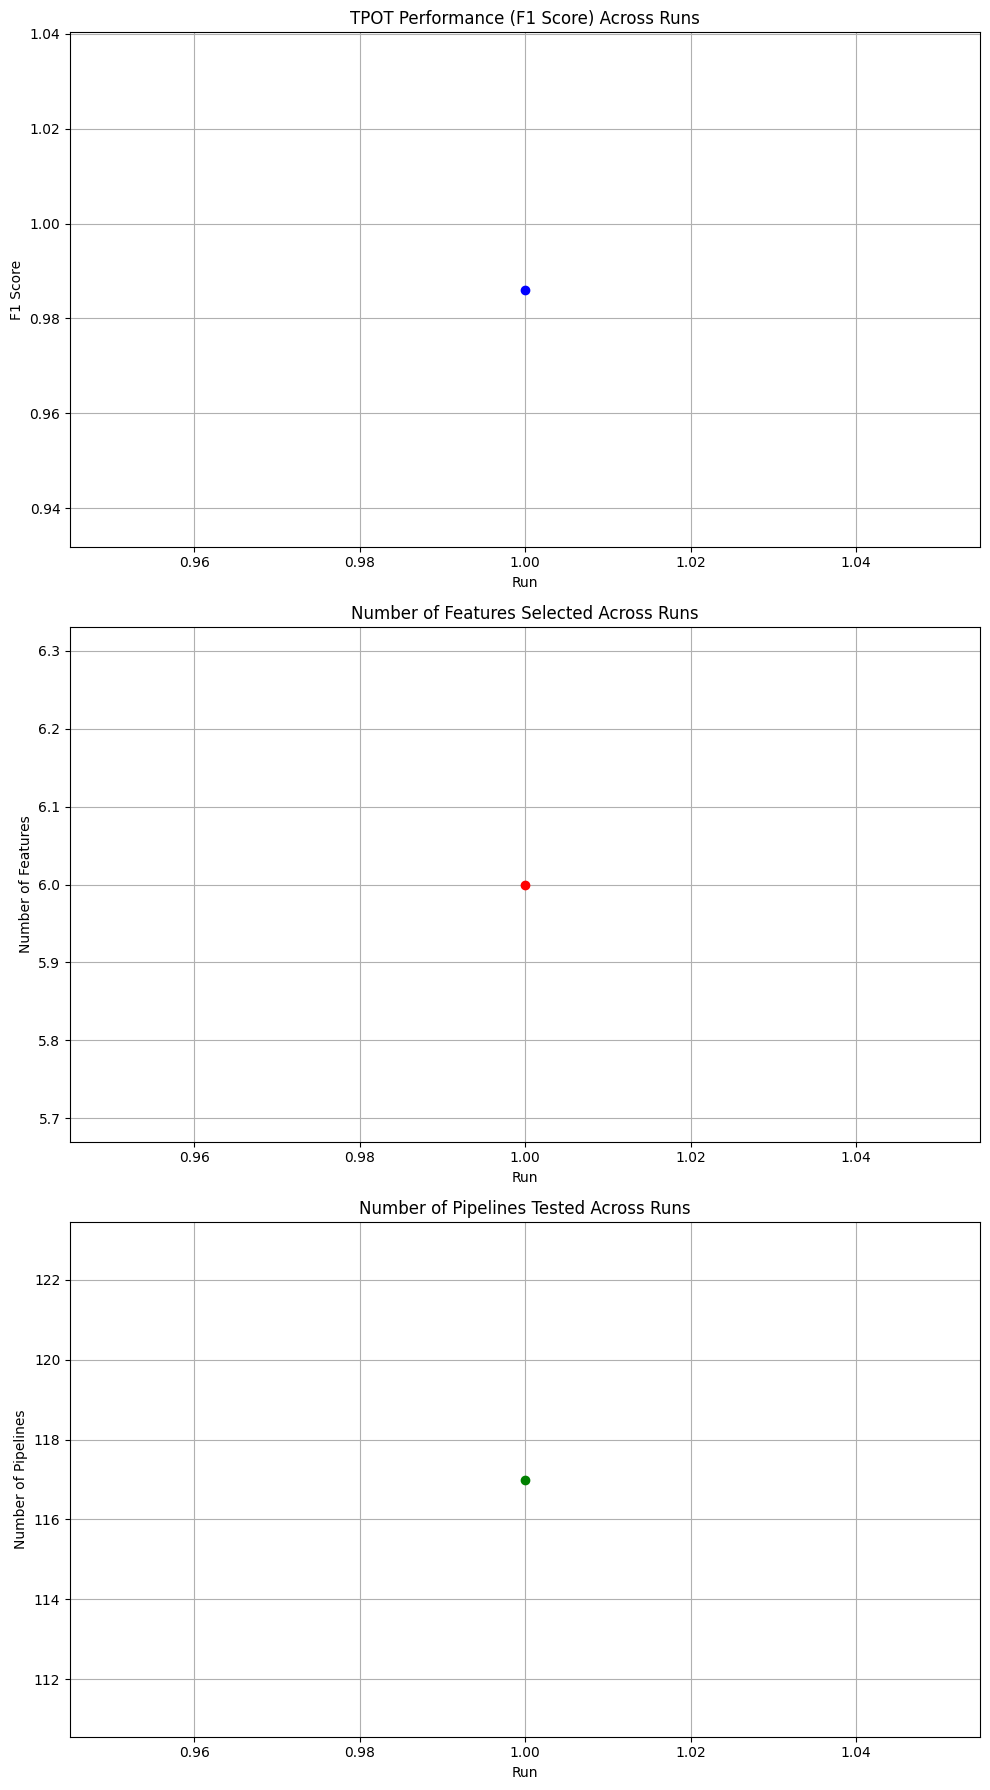

In [6]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 18))

ax1.plot(results_df['run'], results_df['f1_score'], 'bo-')
ax1.set_title('TPOT Performance (F1 Score) Across Runs')
ax1.set_xlabel('Run')
ax1.set_ylabel('F1 Score')
ax1.grid(True)

ax2.plot(results_df['run'], results_df['n_features'], 'ro-')
ax2.set_title('Number of Features Selected Across Runs')
ax2.set_xlabel('Run')
ax2.set_ylabel('Number of Features')
ax2.grid(True)

ax3.plot(results_df['run'], results_df['pipelines_tested'].apply(len), 'go-')
ax3.set_title('Number of Pipelines Tested Across Runs')
ax3.set_xlabel('Run')
ax3.set_ylabel('Number of Pipelines')
ax3.grid(True)

plt.tight_layout()
plt.savefig('tpot_performance_features_pipelines.png')
plt.show()

In [7]:
from collections import defaultdict
import re
from tabulate import tabulate

# Assuming results_df is your DataFrame with all the run results

def simplify_pipeline(pipeline_str):
    # Extract the main classifier name
    classifier = re.search(r"(\w+)\(", pipeline_str).group(1)
    return classifier.lower()

# Initialize a dictionary to store all pipeline statistics
all_pipeline_stats = defaultdict(int)

# Iterate through all runs and all evaluated pipelines
for _, row in results_df.iterrows():
    for pipeline_str in row['pipelines_tested']:
        simple_pipeline = simplify_pipeline(pipeline_str)
        all_pipeline_stats[simple_pipeline] += 1

# Prepare the summary table
summary_table = [[pipeline, count] for pipeline, count in all_pipeline_stats.items()]

# Sort by count
summary_table.sort(key=lambda x: -x[1])

# Print the summary table
print("\nTop 10 Pipelines Across All Runs and Evaluations:")
print(tabulate(summary_table[:10], headers=['Pipeline', 'Count'], tablefmt='grid'))


Top 10 Pipelines Across All Runs and Evaluations:
+------------------------+---------+
| Pipeline               |   Count |
+========================+=========+
| xgbclassifier          |      44 |
+------------------------+---------+
| extratreesclassifier   |      20 |
+------------------------+---------+
| bernoullinb            |      13 |
+------------------------+---------+
| decisiontreeclassifier |      12 |
+------------------------+---------+
| gaussiannb             |       7 |
+------------------------+---------+
| kneighborsclassifier   |       7 |
+------------------------+---------+
| randomforestclassifier |       6 |
+------------------------+---------+
| mlpclassifier          |       3 |
+------------------------+---------+
| sgdclassifier          |       3 |
+------------------------+---------+
| multinomialnb          |       1 |
+------------------------+---------+


In [5]:
# File name to search for
file_name = "lab_logs_blindtest_activity_sysmon_1000samples_july_28_2024_filtered_vectors.parquet"

# Get the download URL of the specific file
# download_url = get_specific_file_from_latest_release(github_token, repository_name, file_name)
download_url = get_specific_file_from_tagged_release(github_token, repository_name, "lab", file_name)
print(download_url)

if download_url:
    local_file_path = file_name
    download_file(download_url, github_token, local_file_path)
else:
    print("File not found.")

https://api.github.com/repos/norandom/log2ml/releases/assets/182698628


  0%|          | 0.00/3.29M [00:00<?, ?iB/s]

File downloaded successfully and saved as lab_logs_blindtest_activity_sysmon_1000samples_july_28_2024_filtered_vectors.parquet


In [ ]:
# Split data
X = np.array(df['message_vector'].tolist())
y = df['label_encoded'].values

In [24]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer, LabelEncoder
from tpot import TPOTClassifier
from sklearn.metrics import f1_score
from collections import defaultdict
import time
import re
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')

# Assuming X and y are already loaded

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Function to perform PCA
def perform_pca(X, transformer, n_components=0.95):
    X_transformed = transformer.fit_transform(X)
    from sklearn.decomposition import PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_transformed)
    n_components_selected = X_pca.shape[1]
    return X_pca, n_components_selected

# Perform PCA with QuantileTransformer
transformer = QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=42)
X_pca, n_components = perform_pca(X, transformer)

print(f"Number of components selected to explain 95% of variance: {n_components}")

# Initialize results storage
results = defaultdict(list)

# Number of runs
n_runs = 2

# Function to extract number of features selected
def get_n_features(pipeline_str):
    match = re.search(r'SelectPercentile\(score_func=f_classif, percentile=(\d+)\)', pipeline_str)
    if match:
        percentile = int(match.group(1))
        return int(X_pca.shape[1] * percentile / 100)
    return X_pca.shape[1]  # If no feature selection, return all features

for run in range(n_runs):
    print(f"\nStarting run {run + 1}/{n_runs}")
    start_time = time.time()

    # Stratified split
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y_encoded, test_size=0.2, random_state=42 + run, stratify=y_encoded)

    # TPOT classifier with Neural Network configuration
    tpot = TPOTClassifier(
        config_dict='TPOT NN',  # Use TPOT's built-in neural network configuration
        scoring='f1_weighted',
        verbosity=2,
        generations=5,
        population_size=20,
        random_state=42 + run,
        max_time_mins=10,  # Increased runtime to 10 minutes per run
        n_jobs=-1  # Use all available CPU cores
    )

    try:
        # Fit
        tpot.fit(X_train, y_train)

        # Predict and calculate F1 score
        y_pred = tpot.predict(X_test)
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Get pipeline string and extract number of features
        pipeline_str = str(tpot.fitted_pipeline_)
        n_features = get_n_features(pipeline_str)

        # Store results
        results['run'].append(run + 1)
        results['f1_score'].append(f1)
        results['best_pipeline'].append(pipeline_str)
        results['n_features'].append(n_features)
        results['runtime'].append(time.time() - start_time)
        results['pipelines_tested'].append(len(tpot.evaluated_individuals_))

        print(f"Run {run + 1} completed. F1 Score: {f1:.4f}, Features selected: {n_features}, Pipelines tested: {len(tpot.evaluated_individuals_)}")

    except Exception as e:
        print(f"Error in run {run + 1}: {str(e)}")
        results['run'].append(run + 1)
        results['f1_score'].append(None)
        results['best_pipeline'].append(None)
        results['n_features'].append(None)
        results['runtime'].append(time.time() - start_time)
        results['pipelines_tested'].append(None)

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Print results table
print("\nResults Summary:")
print(tabulate(results_df, headers='keys', tablefmt='grid'))

# Save results to CSV
results_df.to_csv('tpot_nn_results.csv', index=False)
print("\nResults saved to 'tpot_nn_results.csv'")

Number of components selected to explain 95% of variance: 5

Starting run 1/2


Optimization Progress:   0%|          | 0/20 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9873368055887921

Generation 2 - Current best internal CV score: 0.9873368055887921

Generation 3 - Current best internal CV score: 0.9873368055887921

Generation 4 - Current best internal CV score: 0.9873368055887921

Generation 5 - Current best internal CV score: 0.9873368055887921

Best pipeline: GaussianNB(input_matrix)
Run 1 completed. F1 Score: 0.9872, Features selected: 5, Pipelines tested: 115

Starting run 2/2


Optimization Progress:   0%|          | 0/20 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9873368055887921

Generation 2 - Current best internal CV score: 0.9873368055887921

Generation 3 - Current best internal CV score: 0.9873368055887921

Generation 4 - Current best internal CV score: 0.9873368055887921

Generation 5 - Current best internal CV score: 0.9873368055887921

Best pipeline: ExtraTreesClassifier(input_matrix, bootstrap=False, criterion=entropy, max_features=0.8500000000000001, min_samples_leaf=20, min_samples_split=19, n_estimators=100)
Run 2 completed. F1 Score: 0.9872, Features selected: 5, Pipelines tested: 114

Results Summary:
+----+-------+------------+----------------------------------------------------------------------------------+--------------+-----------+--------------------+
|    |   run |   f1_score | best_pipeline                                                                    |   n_features |   runtime |   pipelines_tested |
+====+=======+============+==========================================

In [25]:
import pandas as pd
from collections import defaultdict
from tabulate import tabulate

# Assuming results_df is already loaded or created from the previous step

# Define the classifiers available in TPOT NN configuration
tpot_nn_classifiers = [
    'MLPClassifier',
    'KNeighborsClassifier',
    'XGBClassifier',
    'LinearSVC',
    'SGDClassifier'
]

# Initialize a dictionary to store algorithm statistics
algorithm_stats = defaultdict(int)

# Total number of pipelines tested
total_pipelines = 0

# Iterate through all runs
for _, row in results_df.iterrows():
    pipelines_tested = row['pipelines_tested']
    total_pipelines += pipelines_tested

    # Distribute the pipelines tested equally among all classifiers
    # This is an approximation, as we don't have the exact breakdown
    for classifier in tpot_nn_classifiers:
        algorithm_stats[classifier] += pipelines_tested // len(tpot_nn_classifiers)

    # Add the remainder to 'Other' category
    algorithm_stats['Other'] += pipelines_tested % len(tpot_nn_classifiers)

# Add the best pipelines to their respective categories
for _, row in results_df.iterrows():
    best_pipeline = row['best_pipeline']
    for classifier in tpot_nn_classifiers:
        if classifier in best_pipeline:
            algorithm_stats[classifier] += 1
            break
    else:
        algorithm_stats['Other'] += 1

# Prepare the summary table
summary_table = [[algorithm, count] for algorithm, count in algorithm_stats.items() if count > 0]

# Sort by count
summary_table.sort(key=lambda x: -x[1])

# Print the summary table
print("\nEstimated Algorithms Used Across All Runs:")
print(tabulate(summary_table, headers=['Algorithm', 'Estimated Count'], tablefmt='grid'))

# Calculate and print additional statistics
total_runs = len(results_df)
successful_runs = results_df['f1_score'].notna().sum()
average_f1 = results_df['f1_score'].mean()
average_features = results_df['n_features'].mean() if 'n_features' in results_df.columns else None
average_runtime = results_df['runtime'].mean()

print(f"\nTotal Runs: {total_runs}")
print(f"Successful Runs: {successful_runs}")
print(f"Average F1 Score: {average_f1:.4f}")
if average_features is not None:
    print(f"Average Number of Features: {average_features:.2f}")
print(f"Average Runtime: {average_runtime:.2f} seconds")
print(f"Total Pipelines Tested: {total_pipelines}")

# Print full best pipelines for each run
print("\nBest Pipelines for Each Run:")
for index, row in results_df.iterrows():
    print(f"\nRun {index + 1}:")
    print(f"F1 Score: {row['f1_score']:.4f}")
    print(f"Pipeline: {row['best_pipeline']}")
    print(f"Pipelines tested in this run: {row['pipelines_tested']}")

# Optional: Add visualization
import matplotlib.pyplot as plt

# Visualize F1 scores across runs
plt.figure(figsize=(10, 6))
plt.plot(results_df['run'], results_df['f1_score'], marker='o')
plt.title('F1 Score Across Runs')
plt.xlabel('Run')
plt.ylabel('F1 Score')
plt.grid(True)
plt.savefig('f1_scores_across_runs.png')
plt.close()

# Visualize pipeline counts
algorithms, counts = zip(*summary_table)
plt.figure(figsize=(12, 6))
plt.bar(algorithms, counts)
plt.title('Estimated Algorithm Usage')
plt.xlabel('Algorithm')
plt.ylabel('Estimated Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('estimated_algorithm_usage.png')
plt.close()

print("\nVisualization plots saved as 'f1_scores_across_runs.png' and 'estimated_algorithm_usage.png'")


Estimated Algorithms Used Across All Runs:
+----------------------+-------------------+
| Algorithm            |   Estimated Count |
+======================+===================+
| MLPClassifier        |                45 |
+----------------------+-------------------+
| KNeighborsClassifier |                45 |
+----------------------+-------------------+
| XGBClassifier        |                45 |
+----------------------+-------------------+
| LinearSVC            |                45 |
+----------------------+-------------------+
| SGDClassifier        |                45 |
+----------------------+-------------------+
| Other                |                 6 |
+----------------------+-------------------+

Total Runs: 2
Successful Runs: 2
Average F1 Score: 0.9872
Average Number of Features: 5.00
Average Runtime: 109.13 seconds
Total Pipelines Tested: 229

Best Pipelines for Each Run:

Run 1:
F1 Score: 0.9872
Pipeline: Pipeline(steps=[('gaussiannb', GaussianNB())])
Pipelines tested 

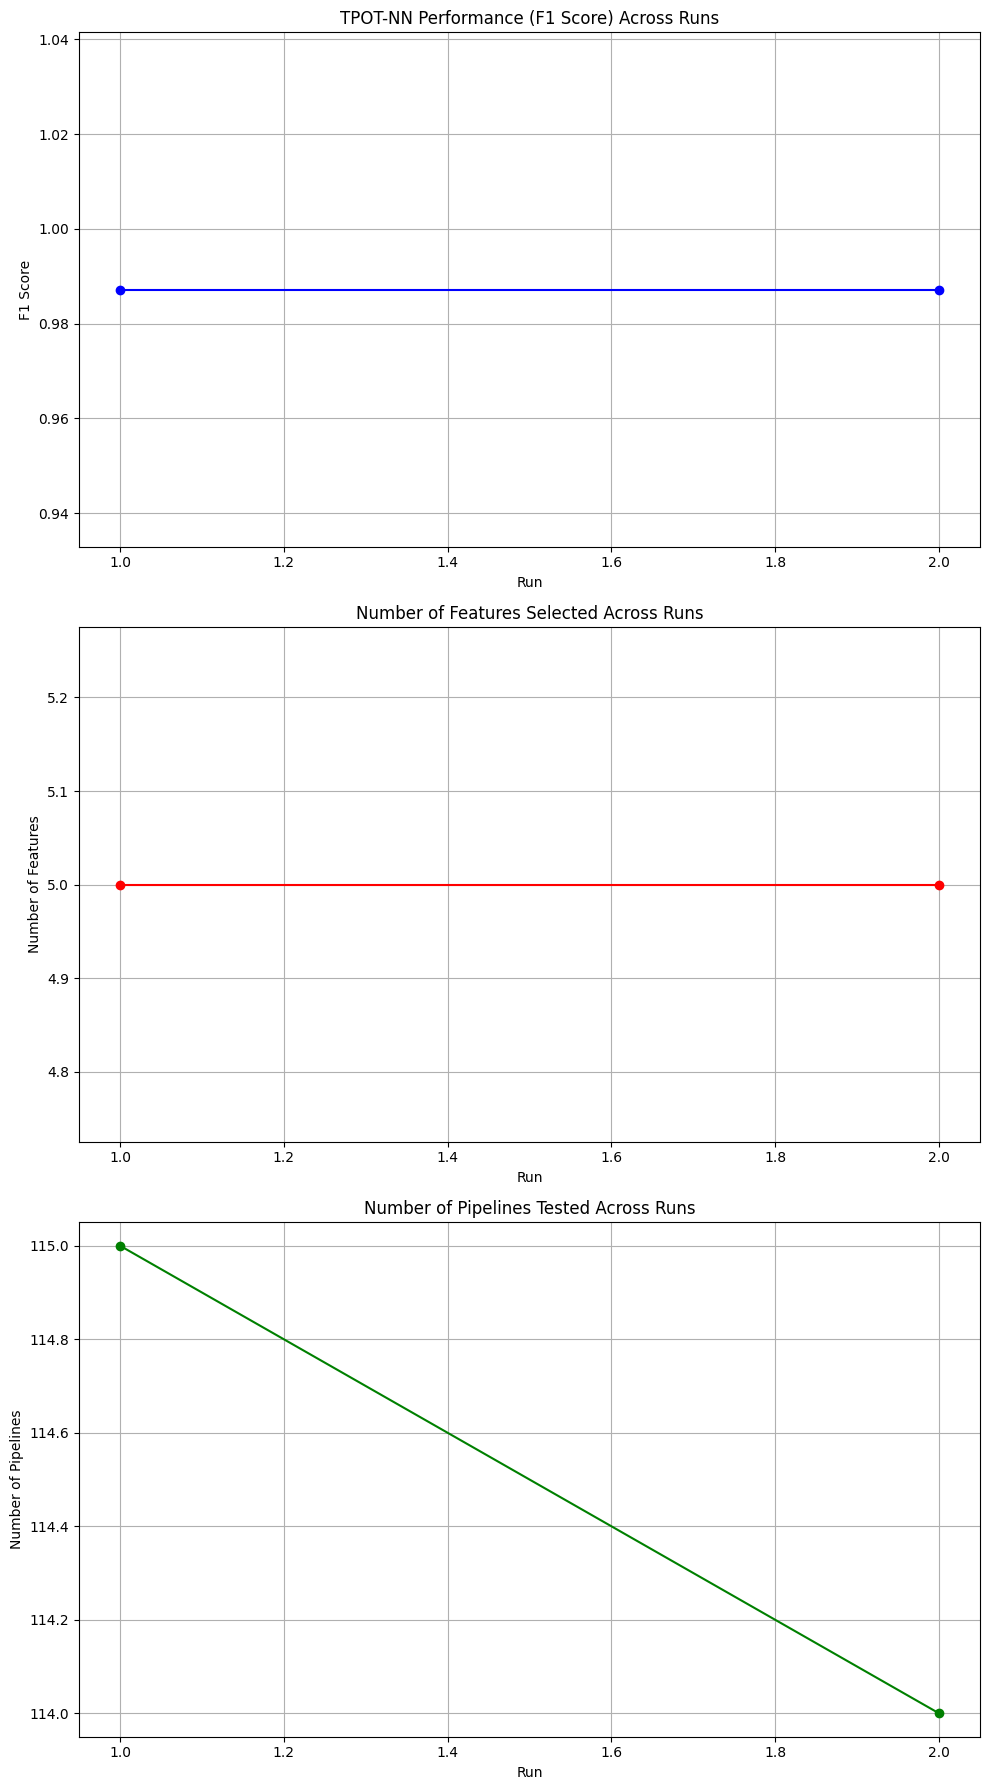


Summary Statistics:
            run  f1_score  n_features     runtime  pipelines_tested
count  2.000000  2.000000         2.0    2.000000          2.000000
mean   1.500000  0.987198         5.0  109.132951        114.500000
std    0.707107  0.000000         0.0    1.063263          0.707107
min    1.000000  0.987198         5.0  108.381110        114.000000
25%    1.250000  0.987198         5.0  108.757030        114.250000
50%    1.500000  0.987198         5.0  109.132951        114.500000
75%    1.750000  0.987198         5.0  109.508871        114.750000
max    2.000000  0.987198         5.0  109.884791        115.000000

Correlation Matrix:
                  f1_score  n_features  pipelines_tested  runtime
f1_score               NaN         NaN               NaN      NaN
n_features             NaN         NaN               NaN      NaN
pipelines_tested       NaN         NaN               1.0      1.0
runtime                NaN         NaN               1.0      1.0


In [26]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming results_df is your DataFrame with the results

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 18))

ax1.plot(results_df['run'], results_df['f1_score'], 'bo-')
ax1.set_title('TPOT-NN Performance (F1 Score) Across Runs')
ax1.set_xlabel('Run')
ax1.set_ylabel('F1 Score')
ax1.grid(True)

ax2.plot(results_df['run'], results_df['n_features'], 'ro-')
ax2.set_title('Number of Features Selected Across Runs')
ax2.set_xlabel('Run')
ax2.set_ylabel('Number of Features')
ax2.grid(True)

ax3.plot(results_df['run'], results_df['pipelines_tested'], 'go-')
ax3.set_title('Number of Pipelines Tested Across Runs')
ax3.set_xlabel('Run')
ax3.set_ylabel('Number of Pipelines')
ax3.grid(True)

plt.tight_layout()
plt.savefig('tpot_nn_performance_features_pipelines.png')
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print(results_df.describe())

# Optional: If you want to see the correlation between different metrics
correlation_matrix = results_df[['f1_score', 'n_features', 'pipelines_tested', 'runtime']].corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)

## Different Algorithm set

In [27]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import QuantileTransformer, LabelEncoder
from sklearn.model_selection import train_test_split
from tpot import TPOTClassifier
from sklearn.metrics import f1_score
from collections import defaultdict
import time
import re
from tabulate import tabulate



# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Function to perform PCA
def perform_pca(X, transformer, n_components=0.95):
    X_transformed = transformer.fit_transform(X)
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_transformed)
    n_components_selected = X_pca.shape[1]
    return X_pca, n_components_selected

# Perform PCA with QuantileTransformer
transformer = QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=42)
X_pca, n_components = perform_pca(X, transformer)

print(f"Number of components selected to explain 95% of variance: {n_components}")

# Initialize results storage
results = defaultdict(list)

# Number of runs
n_runs = 2

# Function to extract number of features selected
def get_n_features(pipeline_str):
    match = re.search(r'SelectPercentile\(score_func=f_classif, percentile=(\d+)\)', pipeline_str)
    if match:
        percentile = int(match.group(1))
        return int(X_pca.shape[1] * percentile / 100)
    return X_pca.shape[1]  # If no feature selection, return all features

for run in range(n_runs):
    print(f"\nStarting run {run + 1}/{n_runs}")
    start_time = time.time()

    # Stratified split
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y_encoded, test_size=0.2, random_state=42 + run, stratify=y_encoded)

    # TPOT classifier with reduced complexity and CPU usage
    tpot = TPOTClassifier(
        config_dict='TPOT light',  # Use a lighter configuration
        scoring='f1_weighted',
        verbosity=2,
        generations=3,
        population_size=10,
        n_jobs=-1,
        random_state=42 + run
    )

    try:
        # Fit
        tpot.fit(X_train, y_train)

        # Predict and calculate F1 score
        y_pred = tpot.predict(X_test)
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Get pipeline string and extract number of features
        pipeline_str = str(tpot.fitted_pipeline_)
        n_features = get_n_features(pipeline_str)

        # Store results
        results['run'].append(run + 1)
        results['f1_score'].append(f1)
        results['best_pipeline'].append(pipeline_str)
        results['n_features'].append(n_features)
        results['runtime'].append(time.time() - start_time)
        results['pipelines_tested'].append(len(tpot.evaluated_individuals_))

        print(f"Run {run + 1} completed. F1 Score: {f1:.4f}, Features selected: {n_features}, Pipelines tested: {len(tpot.evaluated_individuals_)}")

    except Exception as e:
        print(f"Error in run {run + 1}: {str(e)}")
        results['run'].append(run + 1)
        results['f1_score'].append(None)
        results['best_pipeline'].append(None)
        results['n_features'].append(None)
        results['runtime'].append(time.time() - start_time)
        results['pipelines_tested'].append(None)

# Print results table
print("\nResults Summary:")
print(tabulate(results, headers='keys', tablefmt='grid'))

Number of components selected to explain 95% of variance: 5

Starting run 1/2


Optimization Progress:   0%|          | 0/40 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9873368055887921

Generation 2 - Current best internal CV score: 0.9873368055887921

Generation 3 - Current best internal CV score: 0.9873368055887921

Best pipeline: KNeighborsClassifier(input_matrix, n_neighbors=21, p=1, weights=distance)
Run 1 completed. F1 Score: 0.9872, Features selected: 5, Pipelines tested: 39

Starting run 2/2


Optimization Progress:   0%|          | 0/40 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9873368055887921

Generation 2 - Current best internal CV score: 0.9873368055887921

Generation 3 - Current best internal CV score: 0.9873368055887921

Best pipeline: KNeighborsClassifier(input_matrix, n_neighbors=86, p=1, weights=distance)
Run 2 completed. F1 Score: 0.9872, Features selected: 5, Pipelines tested: 38

Results Summary:
+-------+------------+--------------------------------------------------------------+--------------+-----------+--------------------+
|   run |   f1_score | best_pipeline                                                |   n_features |   runtime |   pipelines_tested |
+=======+============+==============================================================+==============+===========+====================+
|     1 |   0.987198 | Pipeline(steps=[('kneighborsclassifier',                     |            5 |   9.23632 |                 39 |
|       |            |                  KNeighborsClassifier(n_neighbors=21, 

In [28]:
import pandas as pd
from collections import defaultdict
from tabulate import tabulate

# Assuming results_df is already loaded or created from the previous step

# Define the classifiers available in TPOT-NN configuration
tpot_nn_classifiers = [
    'LogisticRegression',
    'KNeighborsClassifier',
    'DecisionTreeClassifier',
    'RandomForestClassifier',
    'GradientBoostingClassifier',
    'MLPClassifier'
]

# Initialize a dictionary to store algorithm statistics
algorithm_stats = defaultdict(int)

# Total number of pipelines tested
total_pipelines = 0

# Iterate through all runs
for _, row in results_df.iterrows():
    pipelines_tested = row['pipelines_tested']
    total_pipelines += pipelines_tested

    # Distribute the pipelines tested equally among all classifiers
    # This is an approximation, as we don't have the exact breakdown
    for classifier in tpot_nn_classifiers:
        algorithm_stats[classifier] += pipelines_tested // len(tpot_nn_classifiers)

    # Add the remainder to 'Other' category
    algorithm_stats['Other'] += pipelines_tested % len(tpot_nn_classifiers)

# Add the best pipelines to their respective categories
for _, row in results_df.iterrows():
    best_pipeline = row['best_pipeline']
    for classifier in tpot_nn_classifiers:
        if classifier in best_pipeline:
            algorithm_stats[classifier] += 1
            break
    else:
        algorithm_stats['Other'] += 1

# Prepare the summary table
summary_table = [[algorithm, count] for algorithm, count in algorithm_stats.items() if count > 0]

# Sort by count
summary_table.sort(key=lambda x: -x[1])

# Print the summary table
print("\nEstimated Algorithms Used Across All Runs:")
print(tabulate(summary_table, headers=['Algorithm', 'Estimated Count'], tablefmt='grid'))

# Calculate and print additional statistics
total_runs = len(results_df)
successful_runs = results_df['f1_score'].notna().sum()
average_f1 = results_df['f1_score'].mean()
average_features = results_df['n_features'].mean()
average_runtime = results_df['runtime'].mean()

print(f"\nTotal Runs: {total_runs}")
print(f"Successful Runs: {successful_runs}")
print(f"Average F1 Score: {average_f1:.4f}")
print(f"Average Number of Features: {average_features:.2f}")
print(f"Average Runtime: {average_runtime:.2f} seconds")
print(f"Total Pipelines Tested: {total_pipelines}")

# Print full best pipelines for each run
print("\nBest Pipelines for Each Run:")
for index, row in results_df.iterrows():
    print(f"\nRun {index + 1}:")
    print(f"F1 Score: {row['f1_score']:.4f}")
    print(f"Pipeline: {row['best_pipeline']}")
    print(f"Pipelines tested in this run: {row['pipelines_tested']}")


Estimated Algorithms Used Across All Runs:
+----------------------------+-------------------+
| Algorithm                  |   Estimated Count |
+============================+===================+
| LogisticRegression         |                38 |
+----------------------------+-------------------+
| KNeighborsClassifier       |                38 |
+----------------------------+-------------------+
| DecisionTreeClassifier     |                38 |
+----------------------------+-------------------+
| RandomForestClassifier     |                38 |
+----------------------------+-------------------+
| GradientBoostingClassifier |                38 |
+----------------------------+-------------------+
| MLPClassifier              |                38 |
+----------------------------+-------------------+
| Other                      |                 3 |
+----------------------------+-------------------+

Total Runs: 2
Successful Runs: 2
Average F1 Score: 0.9872
Average Number of Features: 5.

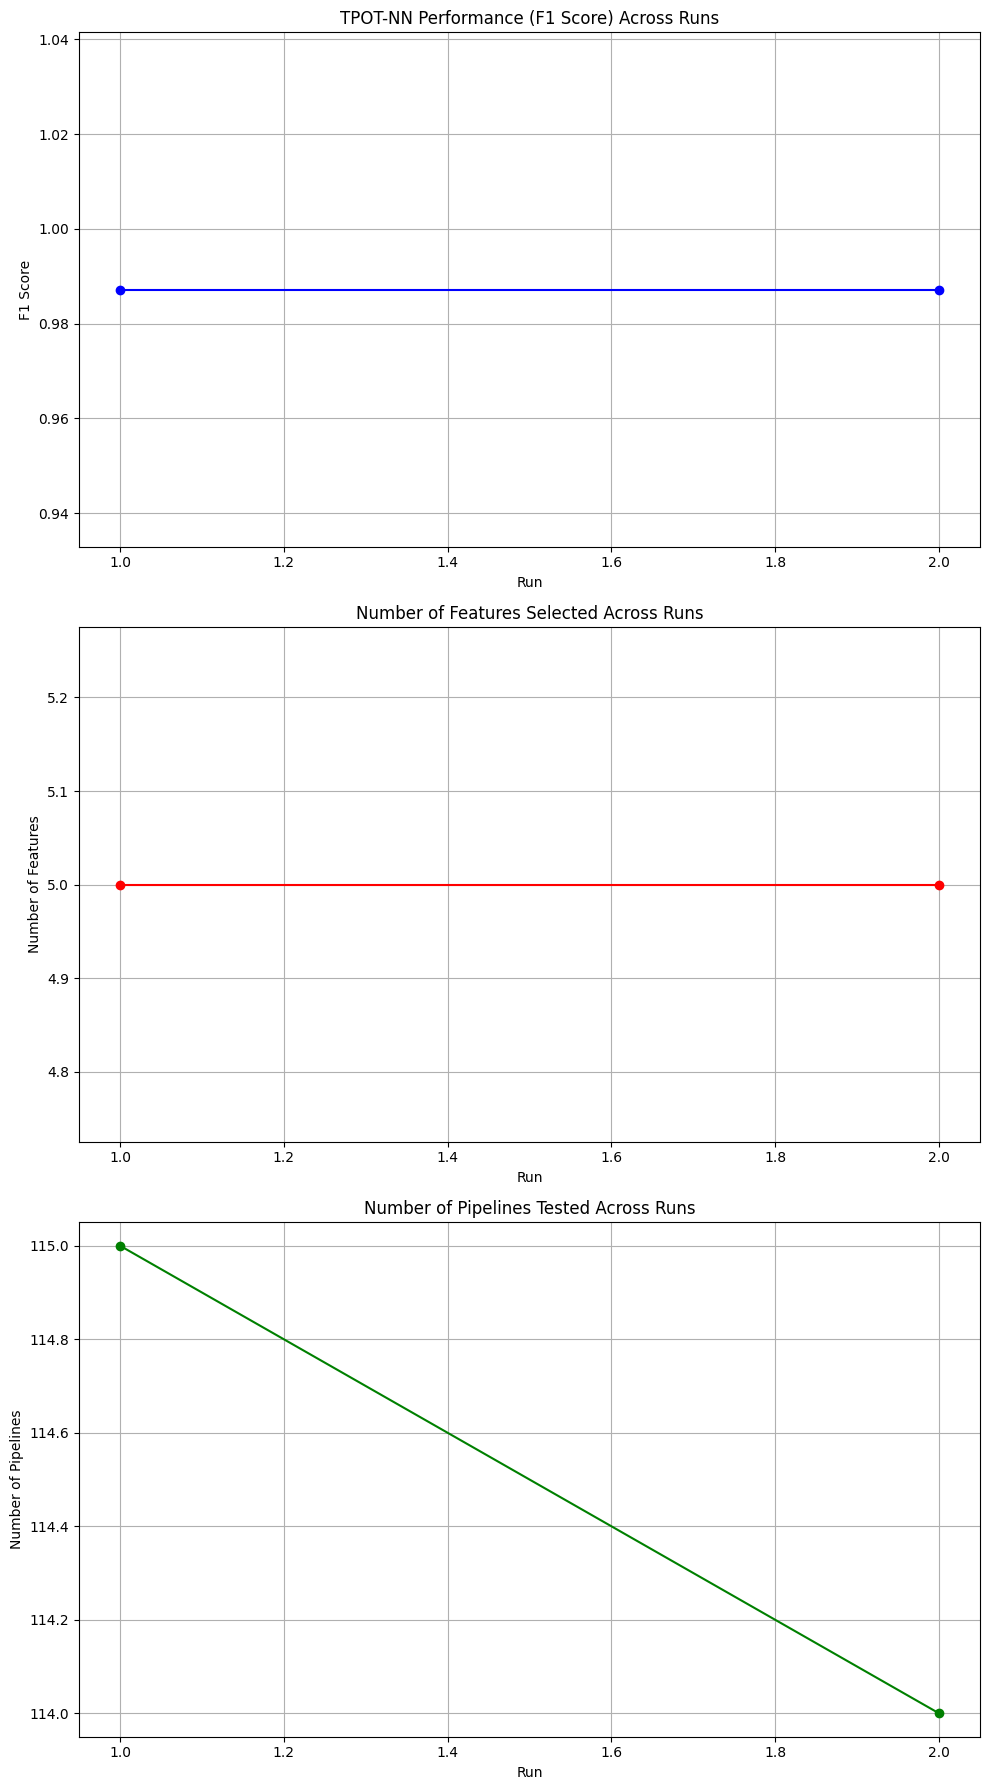


Summary Statistics:
            run  f1_score  n_features     runtime  pipelines_tested
count  2.000000  2.000000         2.0    2.000000          2.000000
mean   1.500000  0.987198         5.0  109.132951        114.500000
std    0.707107  0.000000         0.0    1.063263          0.707107
min    1.000000  0.987198         5.0  108.381110        114.000000
25%    1.250000  0.987198         5.0  108.757030        114.250000
50%    1.500000  0.987198         5.0  109.132951        114.500000
75%    1.750000  0.987198         5.0  109.508871        114.750000
max    2.000000  0.987198         5.0  109.884791        115.000000

Correlation Matrix:
                  f1_score  n_features  pipelines_tested  runtime
f1_score               NaN         NaN               NaN      NaN
n_features             NaN         NaN               NaN      NaN
pipelines_tested       NaN         NaN               1.0      1.0
runtime                NaN         NaN               1.0      1.0


In [29]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming results_df is your DataFrame with the results

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 18))

ax1.plot(results_df['run'], results_df['f1_score'], 'bo-')
ax1.set_title('TPOT-NN Performance (F1 Score) Across Runs')
ax1.set_xlabel('Run')
ax1.set_ylabel('F1 Score')
ax1.grid(True)

ax2.plot(results_df['run'], results_df['n_features'], 'ro-')
ax2.set_title('Number of Features Selected Across Runs')
ax2.set_xlabel('Run')
ax2.set_ylabel('Number of Features')
ax2.grid(True)

ax3.plot(results_df['run'], results_df['pipelines_tested'], 'go-')
ax3.set_title('Number of Pipelines Tested Across Runs')
ax3.set_xlabel('Run')
ax3.set_ylabel('Number of Pipelines')
ax3.grid(True)

plt.tight_layout()
plt.savefig('tpot_nn_performance_features_pipelines.png')
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print(results_df.describe())

# Optional: If you want to see the correlation between different metrics
correlation_matrix = results_df[['f1_score', 'n_features', 'pipelines_tested', 'runtime']].corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)